In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as f
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from time import time

import matplotlib_inline

matplotlib_inline.backend_inline.set_matplotlib_formats("svg")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"

data = pd.read_csv(url, sep=';')
data = data[data['total sulfur dioxide'] < 200]
data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [3]:
data.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1597.000000,1597.000000,1597.000000,1597.000000,1597.000000,1597.000000,1597.000000,1597.000000,1597.000000,1597.000000,1597.000000,1597.000000
mean,8.320163,0.528106,0.270463,2.531590,0.087513,15.847840,46.170946,0.996751,3.311490,0.658334,10.420632,5.634314
std,1.742123,0.178990,0.194384,1.395974,0.047076,10.438642,31.826498,0.001884,0.154115,0.169532,1.064260,0.806630
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997840,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,165.000000,1.003690,4.010000,2.000000,14.900000,8.000000


In [4]:
cols2zscore = data.keys()
cols2zscore = cols2zscore.drop('quality')

# z-score (written out for clarity)
for col in cols2zscore:
    meanval = np.mean(data[col])
    stdev = np.std(data[col], ddof=1)
    data[col] = (data[col] - meanval) / stdev

# can also do more compactly
#data[cols2zscore] = data[cols2zscore].apply(stats.zscore)

data.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1.597000e+03,1.597000e+03,1.597000e+03,1.597000e+03,1.597000e+03,1.597000e+03,1.597000e+03,1.597000e+03,1.597000e+03,1.597000e+03,1.597000e+03,1597.000000
mean,1.779694e-17,1.156801e-16,1.779694e-17,-7.563699e-17,-1.512740e-16,-1.779694e-17,-7.118775e-17,-8.357442e-14,3.025479e-16,8.008622e-17,-5.872989e-16,5.634314
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.806630
min,-2.135419e+00,-2.280048e+00,-1.391387e+00,-1.168783e+00,-1.604073e+00,-1.422392e+00,-1.262186e+00,-3.545821e+00,-3.708218e+00,-1.936711e+00,-1.898626e+00,3.000000
25%,-7.003882e-01,-7.715838e-01,-9.283861e-01,-4.524372e-01,-3.720247e-01,-8.476045e-01,-7.594598e-01,-6.109478e-01,-6.585382e-01,-6.390204e-01,-8.650444e-01,5.000000
50%,-2.411785e-01,-4.528645e-02,-5.382836e-02,-2.375335e-01,-1.808448e-01,-1.770192e-01,-2.567340e-01,-6.214425e-04,-9.670044e-03,-2.261189e-01,-2.073106e-01,6.000000
75%,5.050372e-01,6.251419e-01,7.692848e-01,4.900487e-02,5.281955e-02,4.935662e-01,4.973546e-01,5.778618e-01,5.743113e-01,4.227263e-01,6.383472e-01,6.000000
max,4.350918e+00,5.876831e+00,3.753070e+00,9.289866e+00,1.112001e+01,5.379259e+00,3.733652e+00,3.682565e+00,4.532407e+00,7.913939e+00,4.208902e+00,8.000000


In [5]:
data['boolQuality'] = 0

data['boolQuality'][data['quality'] > 5] = 1

data.head()

/tmp/ipykernel_9462/2255388991.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['boolQuality'][data['quality'] > 5] = 1


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,boolQuality
0,-0.528185,0.960356,-1.391387,-0.452437,-0.244571,-0.464413,-0.382415,0.556633,1.288066,-0.580034,-0.959006,5,0
1,-0.298580,1.965999,-1.391387,0.049005,0.222757,0.876758,0.654456,0.025914,-0.723425,0.127797,-0.583159,5,0
2,-0.298580,1.295570,-1.185609,-0.165899,0.095304,-0.081221,0.245992,0.132058,-0.334104,-0.049161,-0.583159,5,0
3,1.653061,-1.386143,1.489509,-0.452437,-0.265814,0.110375,0.434514,0.662777,-0.982972,-0.462063,-0.583159,6,1
4,-0.528185,0.960356,-1.391387,-0.452437,-0.244571,-0.464413,-0.382415,0.556633,1.288066,-0.580034,-0.959006,5,0


In [6]:
data_tensor = torch.tensor(data[cols2zscore].values).float()
labels_tensor = torch.tensor(data[data.columns[-1]].values).float()

print(data_tensor.shape)
print(labels_tensor.shape)

torch.Size([1597, 11])
torch.Size([1597])


In [7]:
labels_tensor = labels_tensor[:, None]
print(labels_tensor.shape)

torch.Size([1597, 1])


In [8]:
train_data, test_data, train_labels, test_labels = train_test_split(
    data_tensor,
    labels_tensor,
    test_size=.1,
    shuffle=True
)

train_dataset = TensorDataset(train_data, train_labels)
test_dataset = TensorDataset(test_data, test_labels)

In [9]:
class ModelWines(nn.Module):
    def __init__(self):
        super().__init__()

        self.input = nn.Linear(11, 16)
        self.hidden1 = nn.Linear(16, 32)
        self.hidden2 = nn.Linear(32, 32)
        self.output = nn.Linear(32, 1)

    def forward(self, x):
        x = f.relu(self.input(x))
        x = f.relu(self.hidden1(x))
        x = f.relu(self.hidden2(x))
        x = self.output(x)

        return x

In [10]:
def create_dataloaders(batch_size):
    test_data_size = test_dataset.tensors[0].shape[0]
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, drop_last=True)
    test_loader = DataLoader(test_dataset, batch_size=test_data_size)

    return train_loader, test_loader

In [11]:
def create_model():
    model = ModelWines()
    loss_func = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=.01)

    return model, loss_func, optimizer

In [16]:
def train_model(batch_sizes, epochs):
    train_acc_results = np.zeros((epochs, len(batch_sizes)))
    test_acc_results = np.zeros((epochs, len(batch_sizes)))
    computation_time_results = []

    for i, batch_size in enumerate(batch_sizes):
        start_time = time()

        train_acc = []
        test_acc = []

        train_loader, test_loader = create_dataloaders(batch_size)
        model, loss_func, optimizer = create_model()

        model = model.to(device)
        loss_func = loss_func.to(device)

        for _ in range(epochs):
            model.train()

            batch_acc = []

            for X, y in train_loader:
                X = X.to(device)
                y = y.to(device)

                preds = model(X)

                loss = loss_func(preds, y)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                batch_acc.append(100 * torch.mean(((preds > 0) == y).float()).item())

            train_acc.append(np.mean(batch_acc))

            X, y = next(iter(test_loader))
            X = X.to(device)
            y = y.to(device)

            model.eval()
            with torch.no_grad():
                preds = model(X)

            test_acc.append(100 * torch.mean(((preds > 0) == y).float()).item())

        train_acc_results[:, i] = train_acc
        test_acc_results[:, i] = test_acc
        computation_time_results.append(time() - start_time)

    return train_acc_results, test_acc_results, computation_time_results

In [17]:
batch_sizes = [2 ** i for i in range(1, 10, 2)]
epochs = 1000

train_acc, test_acc, computation_time = train_model(batch_sizes, epochs)

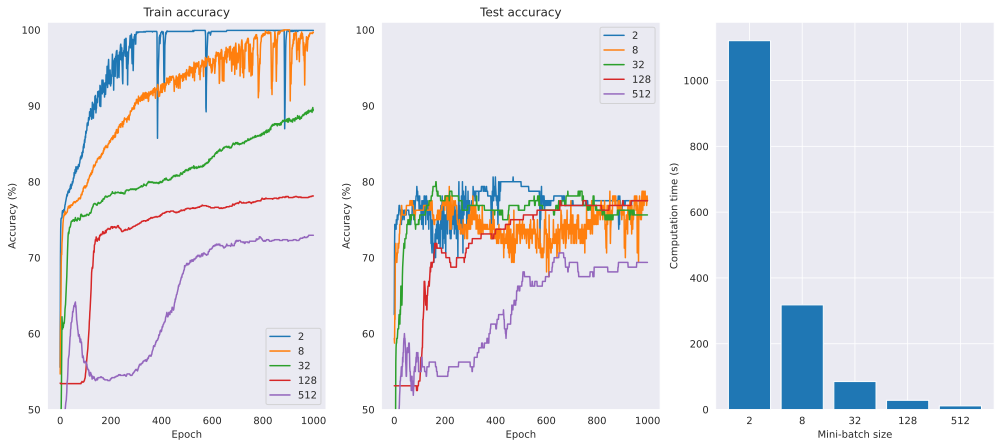

In [28]:
fig, ax = plt.subplots(1, 3, figsize=(17, 7))

ax[0].plot(train_acc)
ax[0].set_title("Train accuracy")
ax[1].plot(test_acc)
ax[1].set_title("Test accuracy")

for i in range(2):
    ax[i].legend(batch_sizes)
    ax[i].set_xlabel("Epoch")
    ax[i].set_ylabel("Accuracy (%)")
    ax[i].set_ylim([50, 101])
    ax[i].grid()

ax[2].bar(range(len(computation_time)), computation_time, tick_label=batch_sizes)
ax[2].set_xlabel('Mini-batch size')
ax[2].set_ylabel('Computation time (s)')

plt.show()